In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [0]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [0]:
data_lm.save()

In [0]:
data = load_data(path)

#Tokenization

In [0]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


#Numericalization


In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

In [0]:
data.train_ds[0][0]

Text xxbos xxmaj want to watch a scary horror film ? xxmaj then steer clear of this one . xxmaj there 's not enough beer in the world to make this film enjoyable . 
 
  xxmaj however , there is enough scotch . xxmaj single - xxunk , if you can manage it . 
 
  xxmaj if the previous comments were n't enough to keep you from watching this film sober , allow me to assist . xxup nasa sends one man and two xxunk extras into space to orbit xxmaj saturn . a really big xxunk xxunk causes xxmaj colonel xxmaj steve xxmaj west to bleed from the nose . xxmaj things go downhill from there , and wackiness ensues . 
 
  i actually read the book adaptation , which was published and released only in the xxup uk . xxup miles better than the film , and the book was dreadful . xxmaj at least some pretense is made towards suspense , and some sort of explanation of events is pulled out from the author 's ( xxunk with ' gas ' ) . 
 
  xxmaj not to say that the film is completely without merit . xxmaj rick xx

In [0]:
data.train_ds[0][0].data[:10]

array([  2,   4, 194,  14, 126,  12, 633, 221,  31,  67])

# with the data block API

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

# Language model

In [0]:
bs=64

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]

In [0]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)


In [0]:
data_lm.show_batch()

idx,text
0,"of the story could have been good , with a better effort to depict the inner feelings of a man who had to live with alcohol and violence since his youth . \n \n xxmaj sadly , the general idea seems to be more like "" i 'm the way i am because that 's the way i am "" . xxmaj and the laughingly bad attempt at giving"
1,"not only do i not care about his suffering , i actually root for it . xxmaj supporting cast members xxmaj mary xxmaj peach and xxmaj ronald xxmaj allen are almost as bad . xxmaj they 're so bland and dull they hardly matter . xxmaj in fact , there 's very little to get excited about while watching xxmaj the xxmaj projected xxmaj man . xxmaj the soundtrack "
2,"gordon xxmaj lewis - esquire moment where xxmaj line plunges her hands into a man 's chest to remove his heart . \n \n xxmaj the best part of the film is the pretty effective zombies who turn up towards the end . xxmaj they 're quickly scared off by a fire though , and do n't bother coming back . xxmaj which is a shame . xxmaj the"
3,"you called it a b - xxmaj western , you 'd be lavishing praise upon it . xxmaj this is what should be called a b - minus xxmaj western perhaps . xxmaj pity xxmaj sterling xxmaj hayden , who appeared at other times along with xxmaj joan xxmaj crawford , xxmaj bette xxmaj davis , xxmaj frank xxmaj sinatra , and other major talents . xxmaj for him to"
4,"xxmaj jack , the xxup d.j. in xxmaj american xxmaj graffiti . i wonder if he 's as well - voiced in the original language . \n \n xxmaj two planets in the movie exploded . xxmaj the explosions were unimpressive , and appeared to owe a lot of inspiration to xxmaj star xxmaj wars . xxmaj to its credit , however , the cause of the explosion was"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


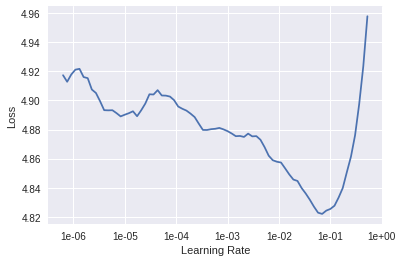

In [0]:
learn.recorder.plot(skip_end=15)


In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.173133,4.010533,0.295576,1:16:15


In [0]:
learn.save('fit_head')


In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.277738,0.208033,0.919160,14:35


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


TypeError: ignored

In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj the premise of this movie has been tickling my imagination for quite some time now . xxmaj we 've all heard or read about it in some kind of con - text . xxmaj what would you do if you were all alone in the world ? xxmaj what would you do if the entire world suddenly disappeared in front of your eyes ? xxmaj in fact ,",pos
"xxbos xxunk ) is the developing world 's answer to xxmaj silence of the xxmaj lambs . xxmaj where ` xxmaj silence ' terrorized our peace of mind , ` xxmaj citizen ' exhausts and saddens us instead . xxmaj this dramatization of the xxmaj chikatilo case translates rather well , thanks to a xxmaj westernized friendship between two xxmaj rostov cops who become equals . \n \n citizenx",pos
"xxbos xxmaj pier xxmaj paolo xxmaj pasolini , or xxmaj pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated xxmaj european xxmaj marxist director - and they are thick on the ground . xxmaj how anyone can see "" art "" in this messy , cheap sex - romp concoction is",neg
"xxbos xxmaj anyone who visited drive - ins in the 1950s , 60s , and 70s , must have seen a film or two by xxmaj american xxmaj international xxmaj pictures , a distributor that resembled 1980s giant xxmaj cannon xxmaj films . xxmaj wherever movie - goers ventured , xxup aip would be right there to supply the latest en vogue titles - in the 50s came horror movies",neg


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


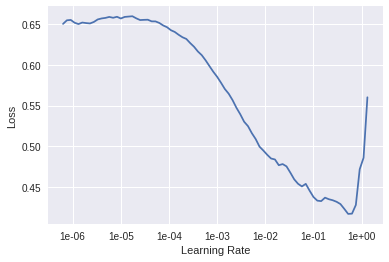

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.291969,0.207594,0.917720,09:09


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.258257,0.188160,0.926840,15:19


In [0]:
learn.save('third')


In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

RuntimeError: ignored

In [0]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([6.3764e-04, 9.9936e-01]))